In [1]:
from BaseModule import *

import numpy as np
import torch
import torch.optim as optim
from torch.autograd import grad
from torch.autograd import Variable
import matplotlib.pyplot as plt
import time
import copy
from scipy.integrate import odeint

dtype = torch.float
import torch.nn as nn
import math


class HydrogenAtom_l0(PotentialBase):
    def __init__(self, t0, tf, x1, neurons, epochs, n_train, lr, minibatch_number):
        super().__init__(t0, tf, x1, neurons, epochs, n_train, lr, minibatch_number)

    def _potential(self, Xs):
        l = 0
        Xsnp = Xs.data.numpy()
        Vnp = 2 / Xsnp - l * (l + 1) / Xsnp ** 2
        Vtorch = torch.from_numpy(Vnp)
        return Vtorch

    def parametricSolutions(self, t, nn):
        N1, N2 = nn(t)
        f = (1 - torch.exp(t - 15))
        psi_hat = f * N1
        return psi_hat

    def _hamEqs_Loss(self, t, psi, E, V):
        psi_dx = dfx(t, psi)
        psi_ddx = dfx(t, psi_dx)
        f = psi_ddx + psi_dx * 2 / t + (2 * E + V) * psi
        L = (f.pow(2)).mean();
        H_psi = -1 * psi_ddx / 2 + (V) * psi
        return L, f, H_psi

    def train(self):
        # 第一个波函数的N(x,lambda)
        N0 = qNN2(self._neurons)

        # N1好像是用来记录整个训练过程中L_DE最小的波函数
        N1 = 0

        betas = [0.999, 0.999]
        optimizer = optim.Adam(N0.parameters(), lr=self._lr, betas=betas)
        # 用来记录Loss
        Loss_history = []

        # 用来判断是否是最小的Loss
        Llim = 1e+20

        # 记录每次学习E_n的变化，即特征值lambda的变化
        En_history = []

        # 用来记录每次训练每个batch的L_DE
        SE_loss_history = []

        #正交损失
        orth_losses = []

        #归一化损失
        nontriv_loss_history = []

        # 用来记录每次训练每个batch的L_DE，最后是用来做patience判断
        internal_SE_loss = []

        orthtime = 2e4

        fc_ground = 0
        fc_first_excited = 0
        # 使用dic字典用来记录每次训练的结果，其中每个元素为元组di，di[0]为qNN1对象，即表示波函数，可以看di=(copy.deepcopy(N0), criteria_loss,En[0].data.tolist()[0] )
        # dic的键表示的是能量？？离谱
        di = (None, 1e+20)
        dic = {}
        for i in range(1000):
            dic[i] = di

        # 在[t0,tf]之间均匀采样，存储到一个列向量中
        grid = torch.linspace(self._t0, self._tf, self._n_train).reshape(-1, 1)

        TeP0 = time.time()

        # 为刚才的均匀采样点增加扰动
        for tt in range(self._epochs):
            x =torch.abs(self._perturbPoints(grid, sig=.03 * self._tf))+ 1e-1

            # 分批次训练
            # BATCHING
            batch_size = int(self._n_train / self._minibatch_number)
            batch_start, batch_end = 0, batch_size

            # 使index随机分布，让每个batch不是依次取点
            idx = np.random.permutation(self._n_train)
            t_b = x[idx]
            t_b.requires_grad = True
            t_f = x[-1]
            t_f = t_f.reshape(-1, 1)
            t_f.requires_grad = True

            # 此时所有采样点存储在t_b中，

            # 存储L_tot
            loss = 0.0
            if tt == orthtime:
                N0.apply(self._weights_init)


            for nbatch in range(self._minibatch_number):
                # 在这个batch中，计算t_b中[batch_start:batch_end]的部分
                t_mb = t_b[batch_start:batch_end].cpu()
                #  Network solutions ,nn为t_mb区间内各采样点的N(x,lambda)，En为其对应的特征值lambda，即能量
                nn, En = N0(t_mb)

                En_history.append(En[0].data.tolist())
                # 当前神经网络N0表示的波函数
                psi = self.parametricSolutions(t_mb, N0).cpu()

                # t_mb对应的势能
                Pot = self._potential(t_mb.cpu())

                # Ltot是L_DE，f是特征方程的残差，H_psi为哈密顿量
                Ltot, f_ret, H_psi = self._hamEqs_Loss(t_mb, psi, En.cpu(), Pot.cpu())
                Ltot *= 1
                SE_loss_history.append(Ltot)

                internal_SE_loss.append(Ltot.cpu().detach().numpy())

                # criteria_loss存储的是L_DE，最后使用criteria_loss跟Llim作判断，判断是否是最小的Llim
                criteria_loss = Ltot

                # +=的部分应该是L_norm
                Ltot += ((self._n_train / (self._tf - self._t0)) * 1.0 - torch.sqrt(
                    torch.dot(psi[:, 0], psi[:, 0]))).pow(2)

                nontriv_loss_history.append(((self._n_train / (self._tf - self._t0)) * 1.0 - torch.sqrt(
                    torch.dot(psi[:, 0], psi[:, 0]))).pow(2))

                # ORTHOLOSS AFTER ORTHTIME
                if tt > 2e4 and tt < 4e4:
                    par2 = self.parametricSolutions(t_mb, fc_ground)
                    ortho_loss = 0.01 * torch.sqrt(
                        torch.dot(par2[:, 0] * t_mb[:, 0], psi[:, 0] * t_mb[:, 0]).pow(2)) / 100
                    orth_losses.append(ortho_loss)
                    Ltot += ortho_loss
                elif tt >= 4e4:
                    par2 = self.parametricSolutions(t_mb, fc_ground)
                    par3 = self.parametricSolutions(t_mb, fc_first_excited)
                    ortho_loss = 0.01 * torch.sqrt(
                        torch.dot((par2[:, 0] + par3[:, 0]) * t_mb[:, 0], psi[:, 0] * t_mb[:, 0]).pow(2)) / 10
                    orth_losses.append(ortho_loss)
                    Ltot += ortho_loss

                if tt % 2000 == 0:
                    print('Epoch', tt)
                    print('E', En_history[-1])
                    print('Ltot', Ltot)
                    print('Llim', Llim)

                Ltot.backward(retain_graph=False)
                optimizer.step()
                loss += Ltot.cpu().data.numpy()
                optimizer.zero_grad()
                batch_start += batch_size
                batch_end += batch_size

            if criteria_loss < Llim:
                N1 = copy.deepcopy(N0)
                Llim = criteria_loss
                if tt < orthtime:
                    fc_ground = copy.deepcopy(N0)


            # 计算本次训练的En的整数部分，将其作为"键"去与dic中记录的波函数作对比
            # 如果本次的criteria_loss更小，则会将dic[key]存储的波函数替换为本次训练出来的神经网络
            E_bin = abs(En[0].data.tolist()[0] // 0.001)
            if criteria_loss < dic[E_bin][1]:
                dic[E_bin] = (copy.deepcopy(N0), criteria_loss, En[0].data.tolist()[0])
            if tt > 3.9e4:
                fc_first_excited = copy.deepcopy(N0)

        self._loss_history = (SE_loss_history, En_history,orth_losses,nontriv_loss_history)
        TePf = time.time()
        print('Training time (minutes):', (TePf - TeP0) / 60)
        return N1, dic, self._loss_history,fc_ground, fc_first_excited


In [2]:

# main function
if __name__ == "__main__":
    a = HydrogenAtom_l0(0.1, 15, 0, 100, int(6e4), 3000, 8e-3, 1)
    N1, dic,loss_history,fc_ground,fc_first = a.train()

Epoch 0
E [-0.18925368785858154]
Ltot tensor(35811.9766, grad_fn=<AddBackward0>)
Llim 1e+20
Epoch 2000
E [-0.030130326747894287]
Ltot tensor(11.4121, grad_fn=<AddBackward0>)
Llim tensor(5.0638, grad_fn=<AddBackward0>)
Epoch 4000
E [-0.1329014003276825]
Ltot tensor(1.1213, grad_fn=<AddBackward0>)
Llim tensor(0.7181, grad_fn=<AddBackward0>)
Epoch 6000
E [-0.1260640174150467]
Ltot tensor(0.2658, grad_fn=<AddBackward0>)
Llim tensor(0.1983, grad_fn=<AddBackward0>)
Epoch 8000
E [-0.13055264949798584]
Ltot tensor(0.1242, grad_fn=<AddBackward0>)
Llim tensor(0.0797, grad_fn=<AddBackward0>)
Epoch 10000
E [-0.12834841012954712]
Ltot tensor(0.2734, grad_fn=<AddBackward0>)
Llim tensor(0.0550, grad_fn=<AddBackward0>)
Epoch 12000
E [-0.13232727348804474]
Ltot tensor(0.4789, grad_fn=<AddBackward0>)
Llim tensor(0.0432, grad_fn=<AddBackward0>)
Epoch 14000
E [-0.1329006850719452]
Ltot tensor(0.3485, grad_fn=<AddBackward0>)
Llim tensor(0.0432, grad_fn=<AddBackward0>)
Epoch 16000
E [-0.13031181693077087]
L

C:\Users\God Hong\Nutstore\1\大三上\量子力学\QMBigHW\BaseModule.py:138: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  torch.nn.init.xavier_uniform(m.weight.data)


Epoch 20000
E [-0.12610678374767303]
Ltot tensor(2635.5977, grad_fn=<AddBackward0>)
Llim tensor(0.0214, grad_fn=<AddBackward0>)
Epoch 22000
E [-0.014910649508237839]
Ltot tensor(39.9820, grad_fn=<AddBackward0>)
Llim tensor(0.0214, grad_fn=<AddBackward0>)
Epoch 24000
E [-0.002579387277364731]
Ltot tensor(2.3200, grad_fn=<AddBackward0>)
Llim tensor(0.0214, grad_fn=<AddBackward0>)
Epoch 26000
E [-0.0008241422474384308]
Ltot tensor(1.7154, grad_fn=<AddBackward0>)
Llim tensor(0.0214, grad_fn=<AddBackward0>)
Epoch 28000
E [-0.0033870451152324677]
Ltot tensor(1.1506, grad_fn=<AddBackward0>)
Llim tensor(0.0214, grad_fn=<AddBackward0>)
Epoch 30000
E [-0.001249849796295166]
Ltot tensor(1.4286, grad_fn=<AddBackward0>)
Llim tensor(0.0214, grad_fn=<AddBackward0>)
Epoch 32000
E [-0.0005590878427028656]
Ltot tensor(1.4448, grad_fn=<AddBackward0>)
Llim tensor(0.0214, grad_fn=<AddBackward0>)
Epoch 34000
E [-0.0008746422827243805]
Ltot tensor(1.2707, grad_fn=<AddBackward0>)
Llim tensor(0.0214, grad_fn=<

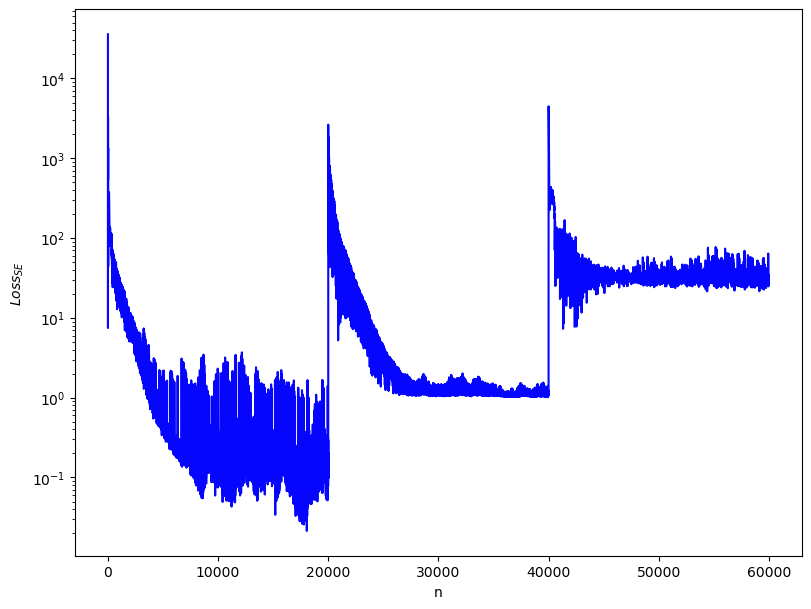

In [3]:
#loss_tot随训练次数的变化
import matplotlib.pyplot as plt
plt.figure(figsize = (8,6))
SH_Loss = [i.detach().numpy() for i in loss_history[0]]
plt.semilogy(SH_Loss, '-b', alpha=0.975)
plt.tight_layout()
    # x_ticks = [10**i for i in range(0, 5)]  # x 轴刻度从 10^0 到 10^4
    # y_ticks = [10**i for i in range(-1, 4)]  # y 轴刻度从 10^-1 到 10^3
plt.ylabel(r'$Loss_{SE}$');plt.xlabel('n')
plt.show()


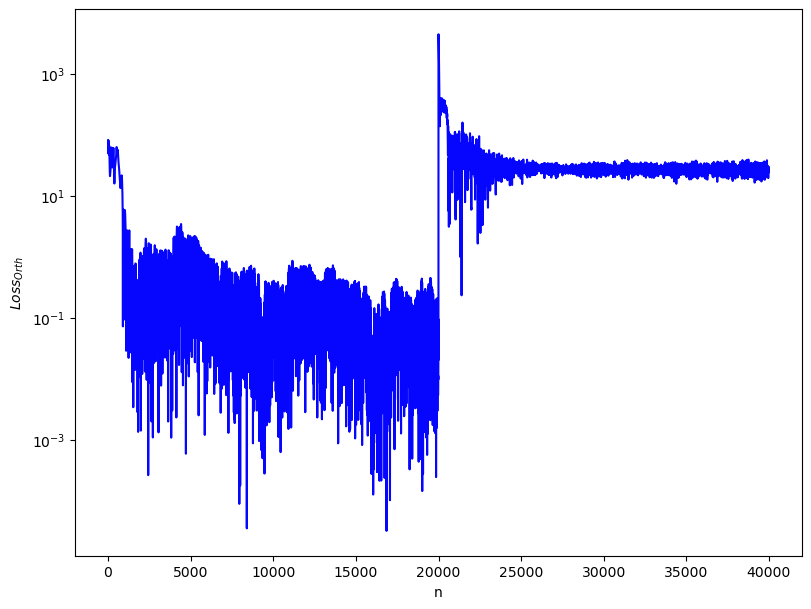

In [4]:
plt.figure(figsize = (8,6))
SH_Loss = [i.detach().numpy() for i in loss_history[2]]
plt.semilogy(SH_Loss, '-b', alpha=0.975)
plt.tight_layout()
    # x_ticks = [10**i for i in range(0, 5)]  # x 轴刻度从 10^0 到 10^4
    # y_ticks = [10**i for i in range(-1, 4)]  # y 轴刻度从 10^-1 到 10^3
plt.ylabel(r'$Loss_{Orth}$');plt.xlabel('n')
plt.show()

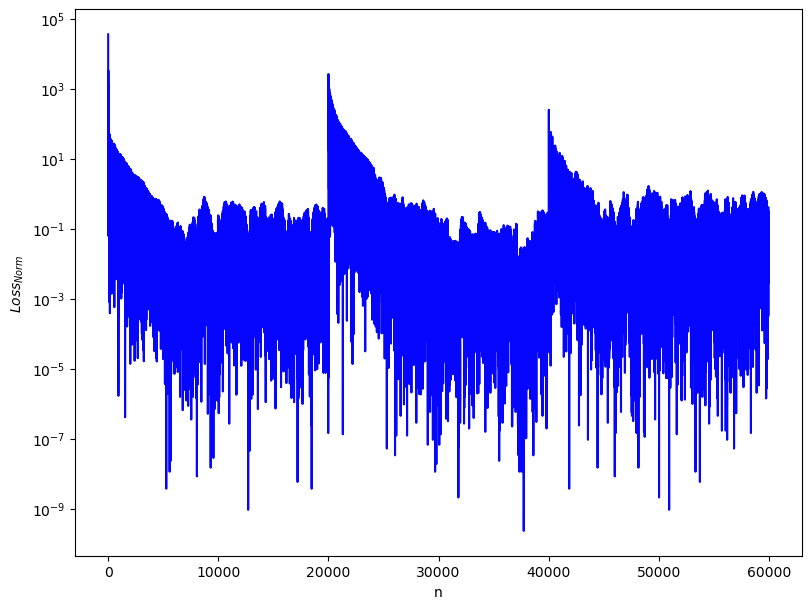

In [5]:
plt.figure(figsize = (8,6))
SH_Loss = [i.detach().numpy() for i in loss_history[3]]
plt.semilogy(SH_Loss, '-b', alpha=0.975)
plt.tight_layout()
    # x_ticks = [10**i for i in range(0, 5)]  # x 轴刻度从 10^0 到 10^4
    # y_ticks = [10**i for i in range(-1, 4)]  # y 轴刻度从 10^-1 到 10^3
plt.ylabel(r'$Loss_{Norm}$');plt.xlabel('n')
plt.show()

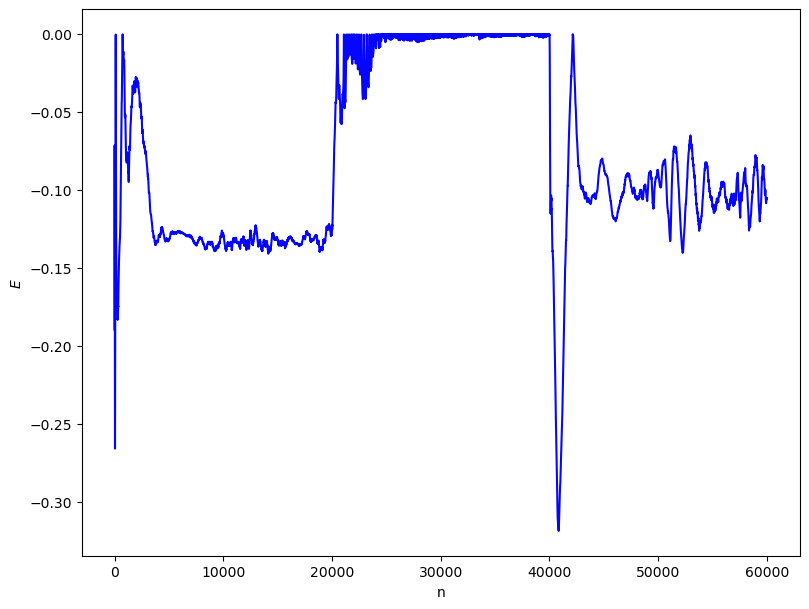

In [6]:
plt.figure(figsize = (8,6))
    #En_history = [i.detach().numpy() for i in loss_history[1]]
En_history=loss_history[1]
plt.plot(En_history, '-b', alpha=0.975)
plt.tight_layout()
    # x_ticks = [10**i for i in range(0, 5)]  # x 轴刻度从 10^0 到 10^4
    # y_ticks = [10**i for i in range(-1, 4)]  # y 轴刻度从 10^-1 到 10^3
plt.ylabel(r'$E$');plt.xlabel('n')
plt.show()

E=-0.08595024049282074


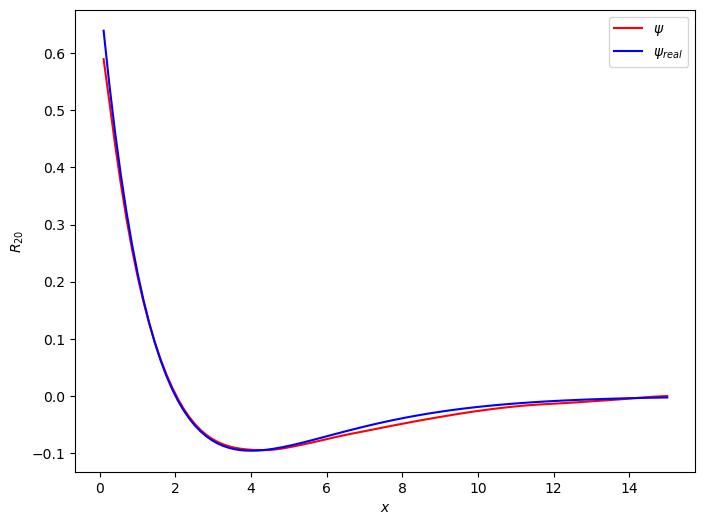

In [24]:
# 绘制psi_0，对psi的幅值进行了缩放
plt.figure(figsize = (8,6))
x = torch.linspace(0.1, 15, 100).reshape(-1, 1)
psy=-a.parametricSolutions(x,dic[13][0])/35.5
psy = [i.detach().numpy() for i in psy]
plt.plot(x, psy,'r')

print(f"E={dic[9][2]}")

x1 = torch.linspace(0.1, 15, 100).reshape(-1, 1)
R_10 = 2 * np.exp(-x1)
R_20 = 1 / np.sqrt(2) * (1 - x1 / 2) * np.exp(-x1 / 2)
R_30 = 2 / 27 * (1 - 2 * x1 / 3 + 2 / 27 * x1 * x1) * np.exp(-x1 / 3)
R_40 = 0.25 * (1 - 3 / 4 * x1 + x1 * x1 / 8 - 1 / 192 * x1 * x1 * x1) * np.exp(-x1 / 4)
plt.plot(x1,R_20, 'b')

plt.ylabel(r'$R_{20}$')  # 使用LaTeX格式的x轴标签
plt.xlabel(r'$x$')  # 使用LaTeX格式的y轴标签
plt.legend(['$\psi$','$\psi_{real}$'])

plt.show()